In [41]:
# start add noise to the image
# what is the relation between error in m vs the noise level applied
# pixel noise vs shape noise (level of 0.2)

# read Dodelson: 1. overview, section 2,4, read section 6,7,8 + magnefication, possibly 9

In [42]:
%load_ext autoreload
%autoreload 2

from utils import get_moments, get_elipticity, get_x_y
import galsim, ngmix

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
#The implementation of shape noise is questionable.

import ngmix
import numpy as np


def sim_func(*, g1, g2, seed, psf_fwhm, pixel_noise_std, shape_noise_std):
    # this is an RNG you can use to draw random numbers as needed
    # always use this RNG and not np.random directly
    # doing this makes sure the code is reproducible
    
    rng = np.random.RandomState(seed=seed)

    shape_nse = rng.normal(loc=0,scale=shape_noise_std)
    # make an Exponential object in galsim with a half light radius of 0.5
    gal = galsim.Exponential(half_light_radius=0.5+shape_nse)

    # make a Gaussian object in galsim with a fwhm of `psf_fwhm`
    psf = galsim.Gaussian(fwhm=psf_fwhm)

    # apply the input shear `g1`, `g2` to the galaxy `gal`
    
    ### draw shear randomly scale=0.3 for shear 
    sheared_gal = gal.shear(g1=g1, g2=g2)

    # here we are going to apply a random shift to the object's center
    dx, dy = 2.0 * (rng.uniform(size=2) - 0.5) * 0.2
    sheared_gal = sheared_gal.shift(dx, dy)

    # convolve the sheared galaxy with the psf
    obj = galsim.Convolve(sheared_gal, psf)

    # render the object and the PSF on odd sized images of 53 pixels on a side with
    # a pixel scale of 0.2
    obj_im = obj.drawImage(scale=0.2, nx=53, ny=53)
    psf_im = psf.drawImage(scale=0.2, nx=53, ny=53)

    # now we are going to add noise to the object image and setup the ngmix data
    cen = (53 - 1) / 2
    nse_sd = pixel_noise_std
    nse = rng.normal(size=obj_im.array.shape, scale=nse_sd)
    nse_im = rng.normal(size=obj_im.array.shape, scale=nse_sd)
    
    jac = ngmix.jacobian.DiagonalJacobian(scale=0.2,
                                          row=cen + dy / 0.2,
                                          col=cen + dx / 0.2)
    psf_jac = ngmix.jacobian.DiagonalJacobian(scale=0.2, row=cen, col=cen)

    # Transformation between pixel and tangent uv coordinate. It has off diag terms if CCD is rotated.
    # in real data we care about off diag terms 

    # we have to add a little noise to the PSf to make things stable
    target_psf_s2n = 500.0
    target_psf_noise = np.sqrt(np.sum(psf_im.array**2)) / target_psf_s2n

    psf_obs = ngmix.Observation(
        image=psf_im.array,
        weight=np.ones_like(psf_im.array) / target_psf_noise**2,
        jacobian=psf_jac,
    )

    # here we build the final observation
    obj_obs = ngmix.Observation(
        image=obj_im.array + nse,
        noise=nse_im,
        weight=np.ones_like(nse_im) / nse_sd**2,
        jacobian=psf_jac,
        bmask=np.zeros_like(nse_im, dtype=np.int32),
        ormask=np.zeros_like(nse_im, dtype=np.int32),
        psf=psf_obs,
    )

    return obj_obs

In [67]:
obs_list_pixel_noise = []
obs_list_shape_noise = []

pixel_noise_std_range = 10**np.linspace(-8,-3,10)
shape_noise_std_range = 10**np.linspace(-8,-1,10)

In [68]:
print(pixel_noise_std_range)
print(shape_noise_std_range)

[1.00000000e-08 3.59381366e-08 1.29154967e-07 4.64158883e-07
 1.66810054e-06 5.99484250e-06 2.15443469e-05 7.74263683e-05
 2.78255940e-04 1.00000000e-03]
[1.00000000e-08 5.99484250e-08 3.59381366e-07 2.15443469e-06
 1.29154967e-05 7.74263683e-05 4.64158883e-04 2.78255940e-03
 1.66810054e-02 1.00000000e-01]


In [46]:
# do your work here!
import mdet_meas_tools as mmt

In [57]:
pixel_noise_std_list = []
for pixel_noise_std_ in pixel_noise_std_range:
    pdata,mdata, m, msd, c, csd  = mmt.run_mdet_sims(sim_func=sim_func,sim_kwargs={'psf_fwhm':0.8, 'pixel_noise_std':pixel_noise_std_,'shape_noise_std':0},seed=123,n_sims=10)
    pixel_noise_std_list.append((msd,csd))
    res = mmt.estimate_m_and_c(pdata,mdata)

    # of sims: 10
    noise cancel m   :  0.378416 +/-  0.001212 [1e-3, 3-sigma]
    noise cancel c   :  0.002399 +/-  0.021011 [1e-5, 3-sigma]


    # of sims: 10
    noise cancel m   :  0.378484 +/-  0.004236 [1e-3, 3-sigma]
    noise cancel c   :  0.009726 +/-  0.075693 [1e-5, 3-sigma]


    # of sims: 10
    noise cancel m   :  0.378731 +/-  0.015123 [1e-3, 3-sigma]
    noise cancel c   :  0.036049 +/-  0.272257 [1e-5, 3-sigma]


    # of sims: 10
    noise cancel m   :  0.379617 +/-  0.054281 [1e-3, 3-sigma]
    noise cancel c   :  0.130530 +/-  0.978900 [1e-5, 3-sigma]


    # of sims: 10
    noise cancel m   :  0.382791 +/-  0.195124 [1e-3, 3-sigma]
    noise cancel c   :  0.470176 +/-  3.521653 [1e-5, 3-sigma]


    # of sims: 10
    noise cancel m   :  0.393955 +/-  0.699643 [1e-3, 3-sigma]
    noise cancel c   :  1.688049 +/-  12.676982 [1e-5, 3-sigma]


    # of sims: 10
    noise cancel m   :  0.450572 +/-  2.547654 [1e-3, 3-sigma]
    noise cancel c   :  6.194707 +/-  45.441774 [1e-5, 3-sigma]


    # of sims: 10
    noise cancel m   :  0.534613 +/-  9.003520 [1e-3, 3-sigma]
    noise cancel c   :  23.573270 +/-  163.203891 [1e-5, 3-sigma]


    # of sims: 10
    noise cancel m   : -0.000710 +/-  32.427355 [1e-3, 3-sigma]
    noise cancel c   :  94.610207 +/-  581.897211 [1e-5, 3-sigma]


    # of sims: 10
    noise cancel m   :  6.796874 +/-  101.809237 [1e-3, 3-sigma]
    noise cancel c   :  395.194165 +/-  2125.002130 [1e-5, 3-sigma]


In [69]:
shape_noise_std_list = []
for shape_noise_std_ in shape_noise_std_range:
    print(shape_noise_std_)
    pdata,mdata, m, msd, c, csd  = mmt.run_mdet_sims(sim_func=sim_func,sim_kwargs={'psf_fwhm':0.8, 'pixel_noise_std':1e-5,'shape_noise_std':shape_noise_std_},seed=123,n_sims=10)
    shape_noise_std_list.append((msd,csd))
    res = mmt.estimate_m_and_c(pdata,mdata)

1e-08


    # of sims: 10
    noise cancel m   :  0.362294 +/-  1.138224 [1e-3, 3-sigma]
    noise cancel c   :  0.777041 +/-  24.014557 [1e-5, 3-sigma]


5.99484250318941e-08


    # of sims: 10
    noise cancel m   :  0.362689 +/-  1.137899 [1e-3, 3-sigma]
    noise cancel c   :  0.777068 +/-  24.014458 [1e-5, 3-sigma]


3.5938136638046254e-07


    # of sims: 10
    noise cancel m   :  0.362517 +/-  1.138016 [1e-3, 3-sigma]
    noise cancel c   :  0.777060 +/-  24.014603 [1e-5, 3-sigma]


2.1544346900318865e-06


    # of sims: 10
    noise cancel m   :  0.361766 +/-  1.138481 [1e-3, 3-sigma]
    noise cancel c   :  0.777192 +/-  24.014539 [1e-5, 3-sigma]


1.2915496650148827e-05


    # of sims: 10
    noise cancel m   :  0.362308 +/-  1.138224 [1e-3, 3-sigma]
    noise cancel c   :  0.777160 +/-  24.014582 [1e-5, 3-sigma]


7.742636826811278e-05


    # of sims: 10
    noise cancel m   :  0.361847 +/-  1.138111 [1e-3, 3-sigma]
    noise cancel c   :  0.777984 +/-  24.015800 [1e-5, 3-sigma]


0.0004641588833612782


    # of sims: 10
    noise cancel m   :  0.359824 +/-  1.137251 [1e-3, 3-sigma]
    noise cancel c   :  0.776525 +/-  24.017202 [1e-5, 3-sigma]


0.0027825594022071257


    # of sims: 10
    noise cancel m   :  0.359210 +/-  1.134633 [1e-3, 3-sigma]
    noise cancel c   :  0.777513 +/-  24.021662 [1e-5, 3-sigma]


0.016681005372000592


    # of sims: 10
    noise cancel m   :  0.355295 +/-  1.133445 [1e-3, 3-sigma]
    noise cancel c   :  0.794496 +/-  24.109023 [1e-5, 3-sigma]


0.1


    # of sims: 10
    noise cancel m   :  0.335823 +/-  1.163018 [1e-3, 3-sigma]
    noise cancel c   :  1.039922 +/-  25.548947 [1e-5, 3-sigma]


In [84]:
def plot_m_and_c(pixel_noise_std_list,shape_noise_std_list):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10,10))
    plt.subplot(2,2,1)
    plt.plot(pixel_noise_std_range,[i[0] for i in pixel_noise_std_list])
    plt.xlabel('pixel noise std')
    plt.ylabel('std of m [1e-3]')
    plt.xscale('log')
    plt.yscale('log')
    plt.subplot(2,2,2)
    plt.plot(pixel_noise_std_range,[i[1] for i in pixel_noise_std_list])
    plt.xlabel('pixel noise std')
    plt.xscale('log')
    plt.yscale('log')
    plt.ylabel('std of c [1e-5]')
    plt.subplot(2,2,3)
    plt.plot(shape_noise_std_range,[i[0] for i in shape_noise_std_list])
    plt.xlabel('shape noise std')
    plt.ylabel('std of m [1e-3]')
    plt.subplot(2,2,4)
    plt.plot(shape_noise_std_range,[i[1] for i in shape_noise_std_list])
    plt.xlabel('shape noise std')
    plt.ylabel('std of c [1e-5]')
    plt.show()

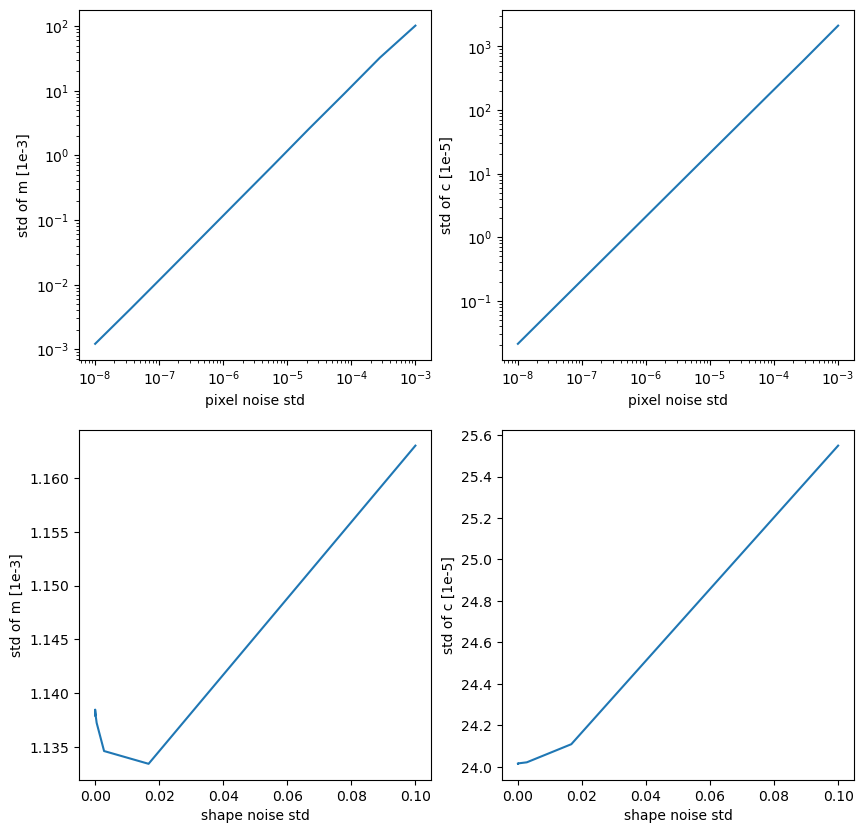

In [85]:
plot_m_and_c(pixel_noise_std_list,shape_noise_std_list)